# Informe de análisis estadístico UNAV (seguimiento semana 2)

En este informe se van a realizar análisis sobre el conjunto de datos proporcioinado por la UNAV (DataSET_SF - V2.xlsx) ya unificado y preparado.

En este conjunto de datos se tiene un registro por oportunidad, siendo este el más reciente; es decir, para cada oportunidad se tiene su último estado.

El objetivo de este análisis es dar respuesta a preguntas que puedan resultar de valor para la UNAV y, que también nos permita detectar errores, tanto en la generación de los datos como en la unión de los mismos.

## Carga de los datos


In [21]:
import pandas as pd

ruta_salida = r"C:\Users\0017655\Downloads\dataset_analisis_final.csv"

# Añadimos low_memory=False para eliminar el warning
datos_analisis = pd.read_csv(ruta_salida, sep=";", low_memory=False)

datos_analisis.head()

,ID,ACCOUNTID,PL_CURSO_ACADEMICO,PL_MES_ANIO_INICIO,PL_TIPO_ACCESO,RECORDTYPEID,RECORDTYPENAME,PL_ESTADO,STAGENAME,PL_SUBETAPA,...,RES_NUMERO_SM_GRADO_ABIERTAS,RES_NUMERO_SM_MASTER_ABIERTAS,COUNT_SBAN,LEADREALINTEREST__PC,PLAZO_ADMISION_LIMPIO,LK_oportunidad__c,FO_rentaFam_ges__c,CU_precioOrdinario_def__c,CU_precioAplicado_def__c,PORCENTAJE_PAGADO_FINAL
0,0066900001W0AKuAAN,0016900002mn3C4AAI,2022/2023,NaN,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Pendiente de validar,Cerrada/Perdida,NaN,...,0.0,0.0,0.0,NaN,Otros,NaN,NaN,NaN,NaN,NaN
1,0066900001cHs6mAAC,0016900002vnlkPAAQ,2022/2023,NaN,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Validado,Cerrada/Perdida,NaN,...,2.0,0.0,0.0,NaN,Otros,NaN,NaN,NaN,NaN,NaN
2,0066900001Ut0u1AAB,0016900002li7RpAAI,2022/2023,NaN,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Pendiente de validar,Cerrada/Perdida,NaN,...,0.0,0.0,0.0,NaN,Otros,NaN,NaN,NaN,NaN,NaN
3,0061r00001KLSSJAA5,0011r00002YMDC6AAP,2022/2023,NaN,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Validado,Reorientación,Respuesta candidato,...,0.0,0.0,0.0,NaN,Otros,NaN,NaN,NaN,NaN,NaN
4,0066900001cHemqAAC,0016900002vnWgVAAU,2022/2023,NaN,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Pendiente de validar,Cerrada/Perdida,NaN,...,0.0,0.0,0.0,NaN,Otros,NaN,NaN,NaN,NaN,NaN


## Análisis por origen de solicitud

1. ¿Hay matriculados con origen de solicitud: Solicitud de Información? ¿Tiene sentido? Cuantificar el número de oportunidades por origen de solicitud que se han matriculado o no se han matriculado.

2. ¿Cuánta información tienen las solicitudes de información y cuanta las solicitudes de admisión? ¿Tiene variables suficientes las solicitudes de información como para poder predecir la probabilidad de matrícula? ¿Debe filtrarse del conjunto de datos y trabajar sólo con las de admisión? ¿Qué variables tiene informadas las solicitudes de admisión? 

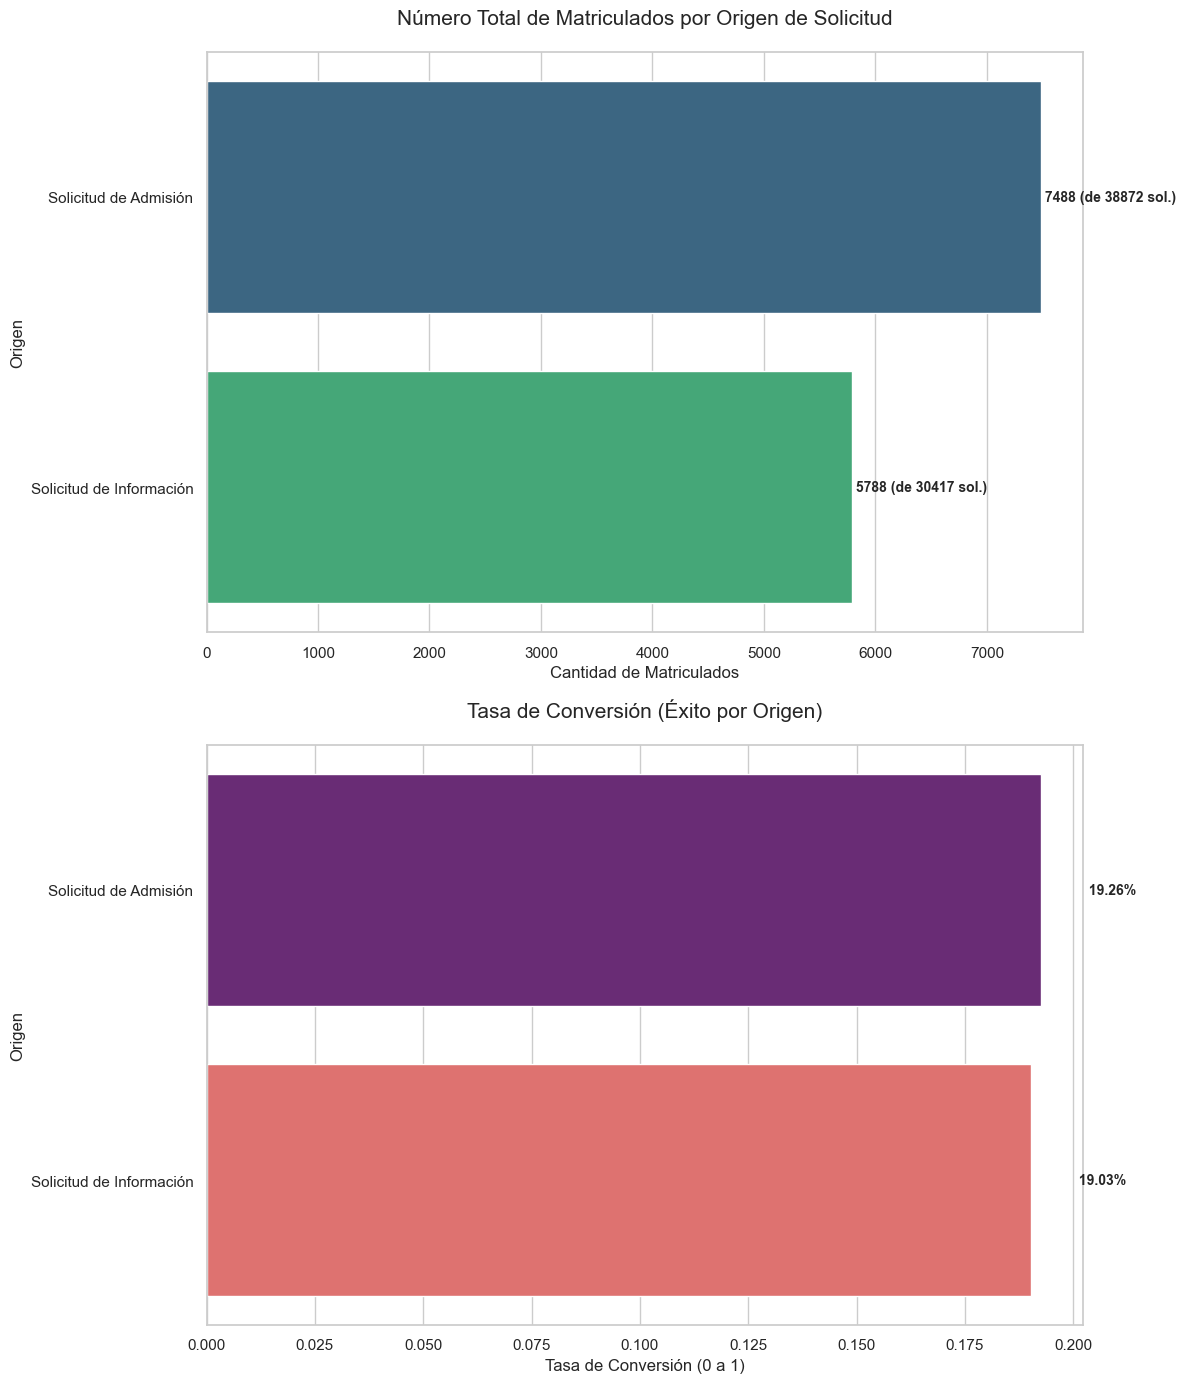

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo
sns.set_theme(style="whitegrid")

# 1. Preparar los datos
resumen = datos_analisis.groupby('PL_ORIGEN_DE_SOLICITUD')['target'].agg(['count', 'sum', 'mean']).reset_index()
resumen.columns = ['Origen', 'Total_Solicitudes', 'Matriculados', 'Tasa_Conversion']
resumen = resumen.sort_values(by='Matriculados', ascending=False)

# Crear la figura con dos subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# --- GRÁFICO 1: Volumen de Matriculados ---
# Añadimos hue='Origen' y legend=False para evitar el FutureWarning
plot1 = sns.barplot(
    data=resumen, 
    x='Matriculados', 
    y='Origen', 
    ax=axes[0], 
    palette='viridis', 
    hue='Origen', 
    legend=False
)
axes[0].set_title('Número Total de Matriculados por Origen de Solicitud', fontsize=15, pad=20)
axes[0].set_xlabel('Cantidad de Matriculados')

# Añadir etiquetas de datos
for i, bar in enumerate(plot1.patches):
    total_sol = resumen.iloc[i]['Total_Solicitudes']
    matriculados = resumen.iloc[i]['Matriculados']
    axes[0].text(matriculados + 0.1, bar.get_y() + bar.get_height()/2, 
                 f' {int(matriculados)} (de {int(total_sol)} sol.)', 
                 va='center', fontsize=10, fontweight='bold')

# --- GRÁFICO 2: Tasa de Conversión ---
resumen_tasa = resumen.sort_values(by='Tasa_Conversion', ascending=False)
# Añadimos hue='Origen' y legend=False aquí también
plot2 = sns.barplot(
    data=resumen_tasa, 
    x='Tasa_Conversion', 
    y='Origen', 
    ax=axes[1], 
    palette='magma', 
    hue='Origen', 
    legend=False
)
axes[1].set_title('Tasa de Conversión (Éxito por Origen)', fontsize=15, pad=20)
axes[1].set_xlabel('Tasa de Conversión (0 a 1)')

# Añadir etiquetas de porcentaje
for i, bar in enumerate(plot2.patches):
    tasa = resumen_tasa.iloc[i]['Tasa_Conversion']
    axes[1].text(tasa + 0.01, bar.get_y() + bar.get_height()/2, 
                 f' {tasa:.2%}', 
                 va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Esto lo que nos sugiere es que hay casos en los que el origen de la solicitud es "Solicitud de información" y se han matriculado. Respecto a la información que nos facilitó la UNAV, no debería haber casos de Solicitud de información que se hayan matriculado porque pasar a la fase de admisión, dicho campo se actualiza directamente ¿es esto así?

In [4]:
# 1. Definimos las columnas que queremos visualizar
columnas_interes = [
    'ID', 
    'PL_ORIGEN_DE_SOLICITUD', 
    'STAGENAME', 
    'PL_SUBETAPA', 
    'target', 
    'CU_precioOrdinario_def__c', 
    'CU_precioAplicado_def__c', 
    'PORCENTAJE_PAGADO_FINAL'
]

# 2. Definimos las condiciones de filtrado
condicion_solicitud = datos_analisis['PL_ORIGEN_DE_SOLICITUD'] == 'Solicitud de Información' 
condicion_matriculado = datos_analisis['target'] == 1

# 3. Filtramos el dataset aplicando AMBOS: filas (condiciones) y columnas (lista)
ejemplos_exito = datos_analisis.loc[condicion_solicitud & condicion_matriculado, columnas_interes]

# 4. Resultados
print(f"Se han encontrado {len(ejemplos_exito)} casos que cumplen ambas condiciones.")

if not ejemplos_exito.empty:
    # Mostramos 3 ejemplos aleatorios (o head(3) si prefieres los primeros)
    display(ejemplos_exito.sample(min(3, len(ejemplos_exito))))
else:
    print("No se encontraron registros con ambos criterios simultáneamente.")

Se han encontrado 5788 casos que cumplen ambas condiciones.


,ID,PL_ORIGEN_DE_SOLICITUD,STAGENAME,PL_SUBETAPA,target,CU_precioOrdinario_def__c,CU_precioAplicado_def__c,PORCENTAJE_PAGADO_FINAL
57895,006Tr00000QiW6sIAF,Solicitud de Información,Matrícula OOGG,Formalizada,1,14800.2,13616.4,92.001459
14901,0066900001NB1O0AAL,Solicitud de Información,Matrícula OOGG,Formalizada,1,NaN,NaN,NaN
60020,006Tr00000DeIOXIA3,Solicitud de Información,Matrícula OOGG,Formalizada,1,15700.2,7849.8,49.998089


En el ejemplo que hemos sacado se pueden ver casos en los que la matrícula está formalizada, y el origen de solicitud sigue como 'Solicitud de información'.

## Análisis de los desmatriculados

En este apartado, se va a realizar un análisis de los desmatriculados. Intentando dar respuesta a las siguientes preguntas:

1. ¿Qué titulaciones son las que tienen una mayor tasa de desmatriculación? (Número de desmatriculados entre oportunidades totales)

2. ¿Qué titulaciones son las que tienen un mayor número total de desmatriculados? ¿Cómo se distribuyen las notas finales de admisión para esas carreras entre matriculados y no matriculados? ¿Hay diferencia en las notas de admisión entre los alumnos matriculados y desmatriculados según el plazo de admisión?


Para ello, lo primero que mostramos es el gráfico de las titulaciones con mayor tasa de desmatriculaciones:

--- ANÁLISIS GLOBAL ---
Total de registros: 70299
Total desmatriculados: 1495
Porcentaje de desmatriculaciones: 2.13%
------------------------------


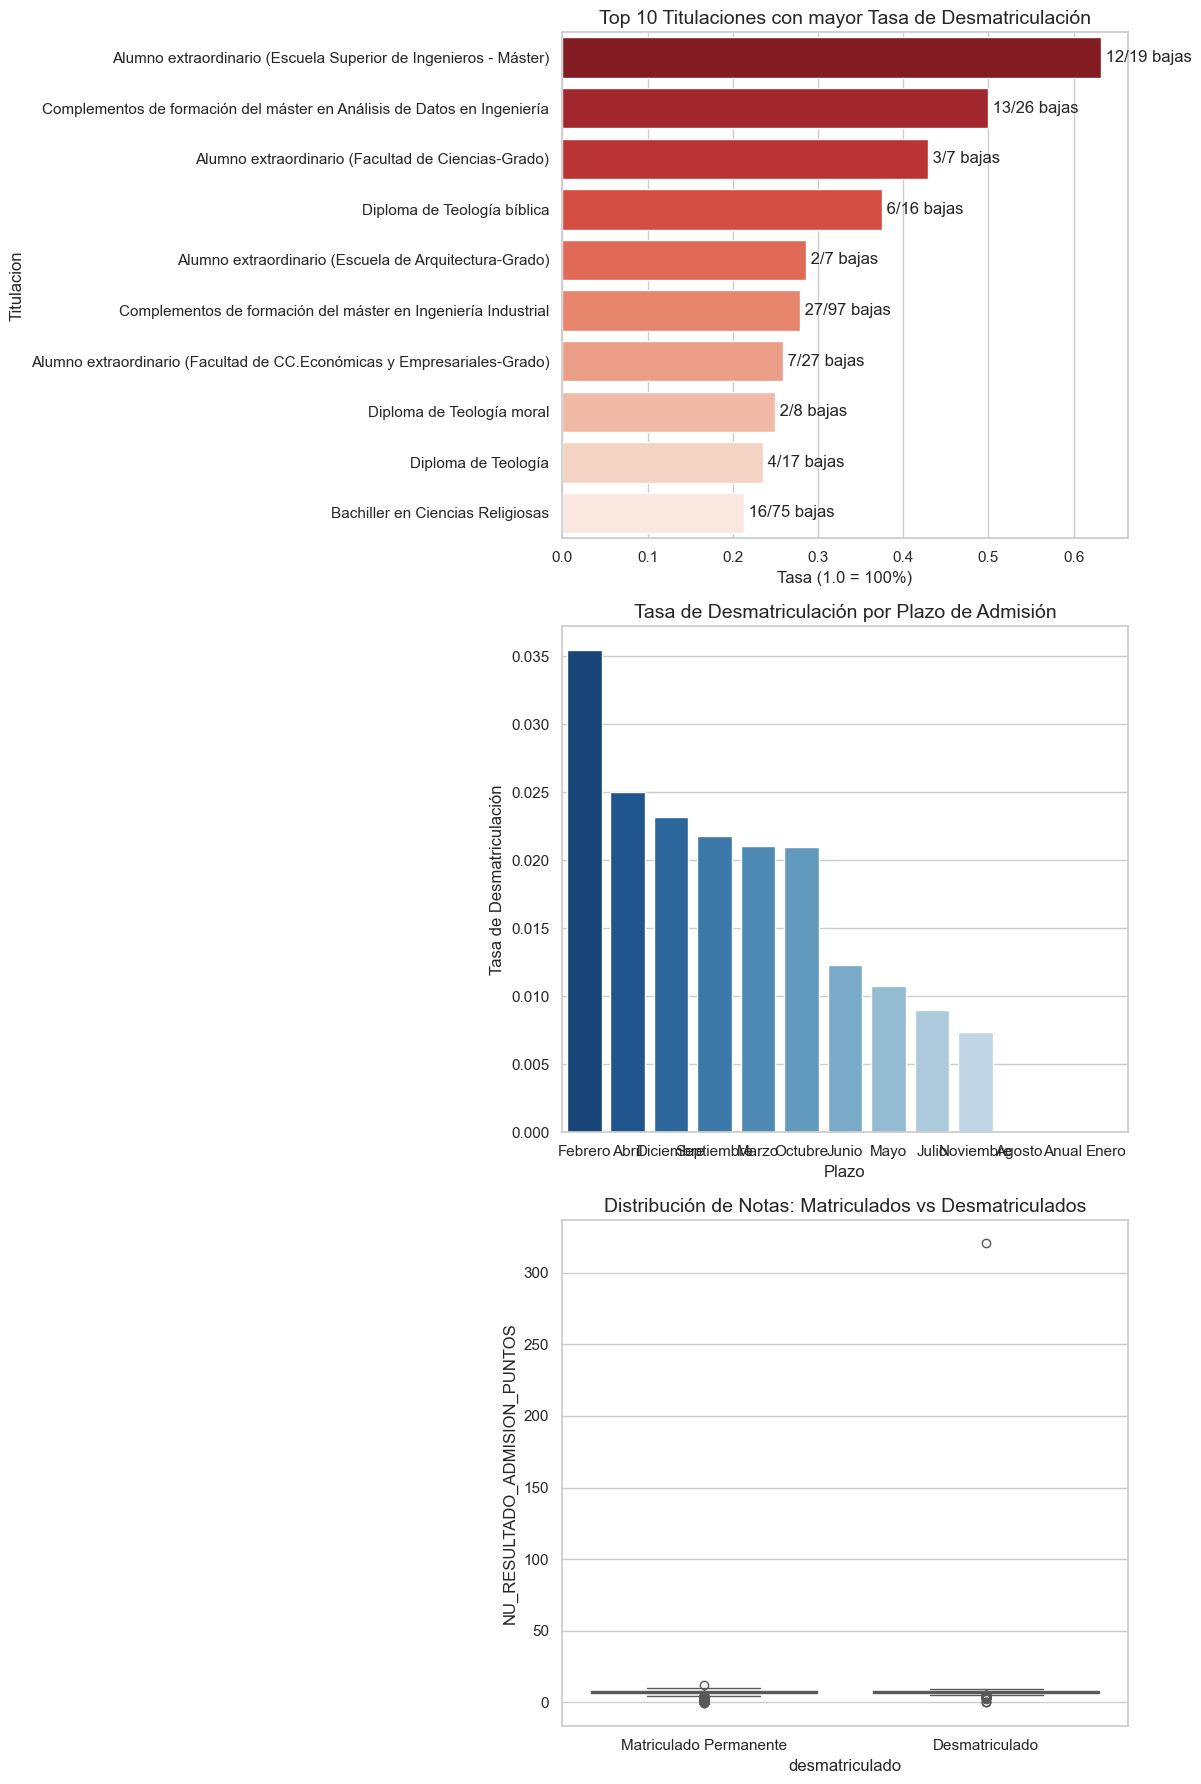


--- TABLA RESUMEN POR PLAZO ---
     Plazo  Total  Bajas     Tasa
   Febrero   4881    173 0.035444
     Abril   9779    245 0.025054
 Diciembre  18051    418 0.023157
Septiembre    275      6 0.021818
     Marzo  12049    254 0.021081
   Octubre   7201    151 0.020969
     Junio   3325     41 0.012331
      Mayo   3157     34 0.010770
     Julio   3217     29 0.009015
 Noviembre    136      1 0.007353
    Agosto      3      0 0.000000
     Anual      1      0 0.000000
     Enero    140      0 0.000000


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 16)

# =========================================================
# 1. ANÁLISIS GLOBAL
# =========================================================
total_casos = len(datos_analisis)
total_desmatriculados = datos_analisis['desmatriculado'].sum()
porcentaje_desmatriculados = (total_desmatriculados / total_casos) * 100

print(f"--- ANÁLISIS GLOBAL ---")
print(f"Total de registros: {total_casos}")
print(f"Total desmatriculados: {total_desmatriculados}")
print(f"Porcentaje de desmatriculaciones: {porcentaje_desmatriculados:.2f}%")
print("-" * 30)

# Preparar la figura
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# =========================================================
# 2. POR TITULACIÓN
# =========================================================
tit_stats = datos_analisis.groupby('TITULACION')['desmatriculado'].agg(['count', 'sum', 'mean']).reset_index()
tit_stats.columns = ['Titulacion', 'Total_Inscritos', 'Bajas', 'Tasa_Desmatriculacion']
tit_stats = tit_stats[tit_stats['Total_Inscritos'] > 5].sort_values(by='Tasa_Desmatriculacion', ascending=False).head(10)

# Corrección: hue='Titulacion' y legend=False
sns.barplot(data=tit_stats, x='Tasa_Desmatriculacion', y='Titulacion', ax=axes[0], 
            palette='Reds_r', hue='Titulacion', legend=False)
axes[0].set_title('Top 10 Titulaciones con mayor Tasa de Desmatriculación', fontsize=14)
axes[0].set_xlabel('Tasa (1.0 = 100%)')

for i, bar in enumerate(axes[0].patches):
    bajas = tit_stats.iloc[i]['Bajas']
    total = tit_stats.iloc[i]['Total_Inscritos']
    axes[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {bajas}/{total} bajas', va='center')

# =========================================================
# 3. POR PLAZO DE ADMISIÓN
# =========================================================
plazo_stats = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].agg(['count', 'sum', 'mean']).reset_index()
plazo_stats.columns = ['Plazo', 'Total', 'Bajas', 'Tasa']
plazo_stats = plazo_stats.sort_values(by='Tasa', ascending=False)

# Corrección: hue='Plazo' y legend=False
sns.barplot(data=plazo_stats, x='Plazo', y='Tasa', ax=axes[1], 
            palette='Blues_r', hue='Plazo', legend=False)
axes[1].set_title('Tasa de Desmatriculación por Plazo de Admisión', fontsize=14)
axes[1].set_ylabel('Tasa de Desmatriculación')

# =========================================================
# 4. NOTAS DE ADMISIÓN
# =========================================================
# Corrección: hue='desmatriculado' y legend=False
sns.boxplot(data=datos_analisis, x='desmatriculado', y='NU_RESULTADO_ADMISION_PUNTOS', ax=axes[2], 
            palette='Set2', hue='desmatriculado', legend=False)
axes[2].set_title('Distribución de Notas: Matriculados vs Desmatriculados', fontsize=14)

# Corrección moderna para etiquetas de eje
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Matriculado Permanente', 'Desmatriculado'])

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\n--- TABLA RESUMEN POR PLAZO ---")
print(plazo_stats[['Plazo', 'Total', 'Bajas', 'Tasa']].to_string(index=False))

Aquí podemos observar lo siguiente:

1. Las titulaciones que tienen una mayor tasa de desmatriculación es debido a que tiene muy pocas oportunidades asociadas, por lo que en una variación pequeña de las desmatriculaciones, hay un aumento muy grande de la tasa.

2. Podemos ver que las tasas de desmatriculaciones son más altas en febrero, aunque en diciembre hay más desmatriculaciones, pero al haber más oportunidades, la tasa es menor.

A continuación, se muestra un gráfico de la distribución de notas de admisiñon entre matriculados y no matriculados.

No se ve una diferencia significativa en las notas de matriculados y no matriculados.

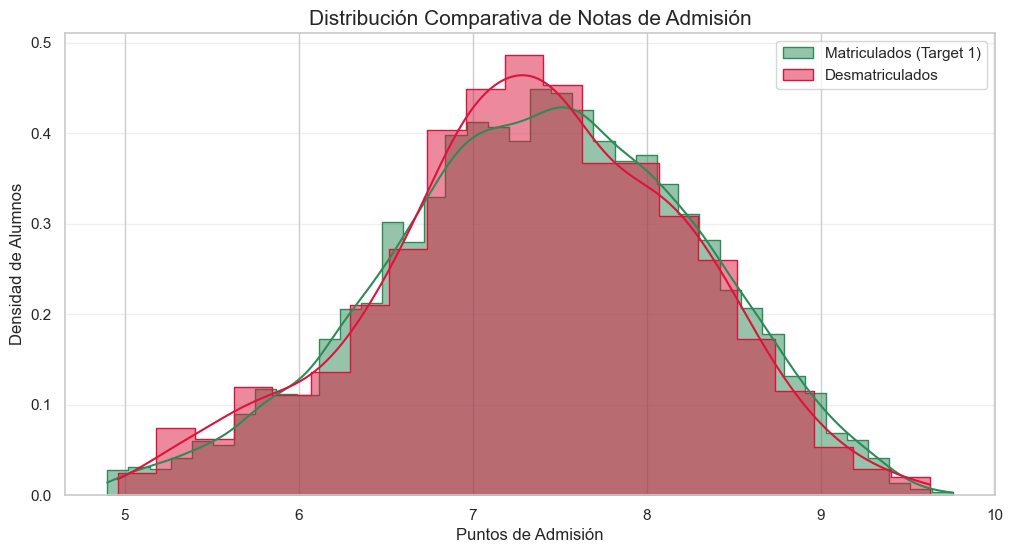

Media de nota (Matriculados): 7.39
Media de nota (Desmatriculados): 7.35
Diferencia real: 0.04 puntos


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar los grupos (Filtrado estricto)
# Grupo Matriculados: target=1 y no se han ido
# Grupo Desmatriculados: los que tienen la marca de desmatriculado
df_mat = datos_analisis[(datos_analisis['target'] == 1) & (datos_analisis['desmatriculado'] == 0)].copy()
df_des = datos_analisis[datos_analisis['desmatriculado'] == 1].copy()

# 2. Función para limpiar outliers (IQR)
def limpiar_outliers(df, col):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    return df[(df[col] >= (q1 - 1.5 * iqr)) & (df[col] <= (q3 + 1.5 * iqr))]

# Limpiamos ambos datasets por separado
df_mat_clean = limpiar_outliers(df_mat.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS']), 'NU_RESULTADO_ADMISION_PUNTOS')
df_des_clean = limpiar_outliers(df_des.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS']), 'NU_RESULTADO_ADMISION_PUNTOS')

# 3. Gráfico de Distribución (Histograma + KDE)
plt.figure(figsize=(12, 6))

# Distribución Matriculados
sns.histplot(df_mat_clean['NU_RESULTADO_ADMISION_PUNTOS'], 
             color="seagreen", label="Matriculados (Target 1)", 
             kde=True, stat="density", alpha=0.5, element="step")

# Distribución Desmatriculados
sns.histplot(df_des_clean['NU_RESULTADO_ADMISION_PUNTOS'], 
             color="crimson", label="Desmatriculados", 
             kde=True, stat="density", alpha=0.5, element="step")

# Personalización
plt.title('Distribución Comparativa de Notas de Admisión', fontsize=15)
plt.xlabel('Puntos de Admisión')
plt.ylabel('Densidad de Alumnos')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

# 4. Cálculo de la diferencia de medias
media_mat = df_mat_clean['NU_RESULTADO_ADMISION_PUNTOS'].mean()
media_des = df_des_clean['NU_RESULTADO_ADMISION_PUNTOS'].mean()
print(f"Media de nota (Matriculados): {media_mat:.2f}")
print(f"Media de nota (Desmatriculados): {media_des:.2f}")
print(f"Diferencia real: {abs(media_mat - media_des):.2f} puntos")

Como podéis observar, la tasa no nos ayuda a entender el problema de las desmatriculaciones, por lo que, se va a analizar las desmatriculaciones de forma total y no en tasa, analizándolo por titulación y plazo.


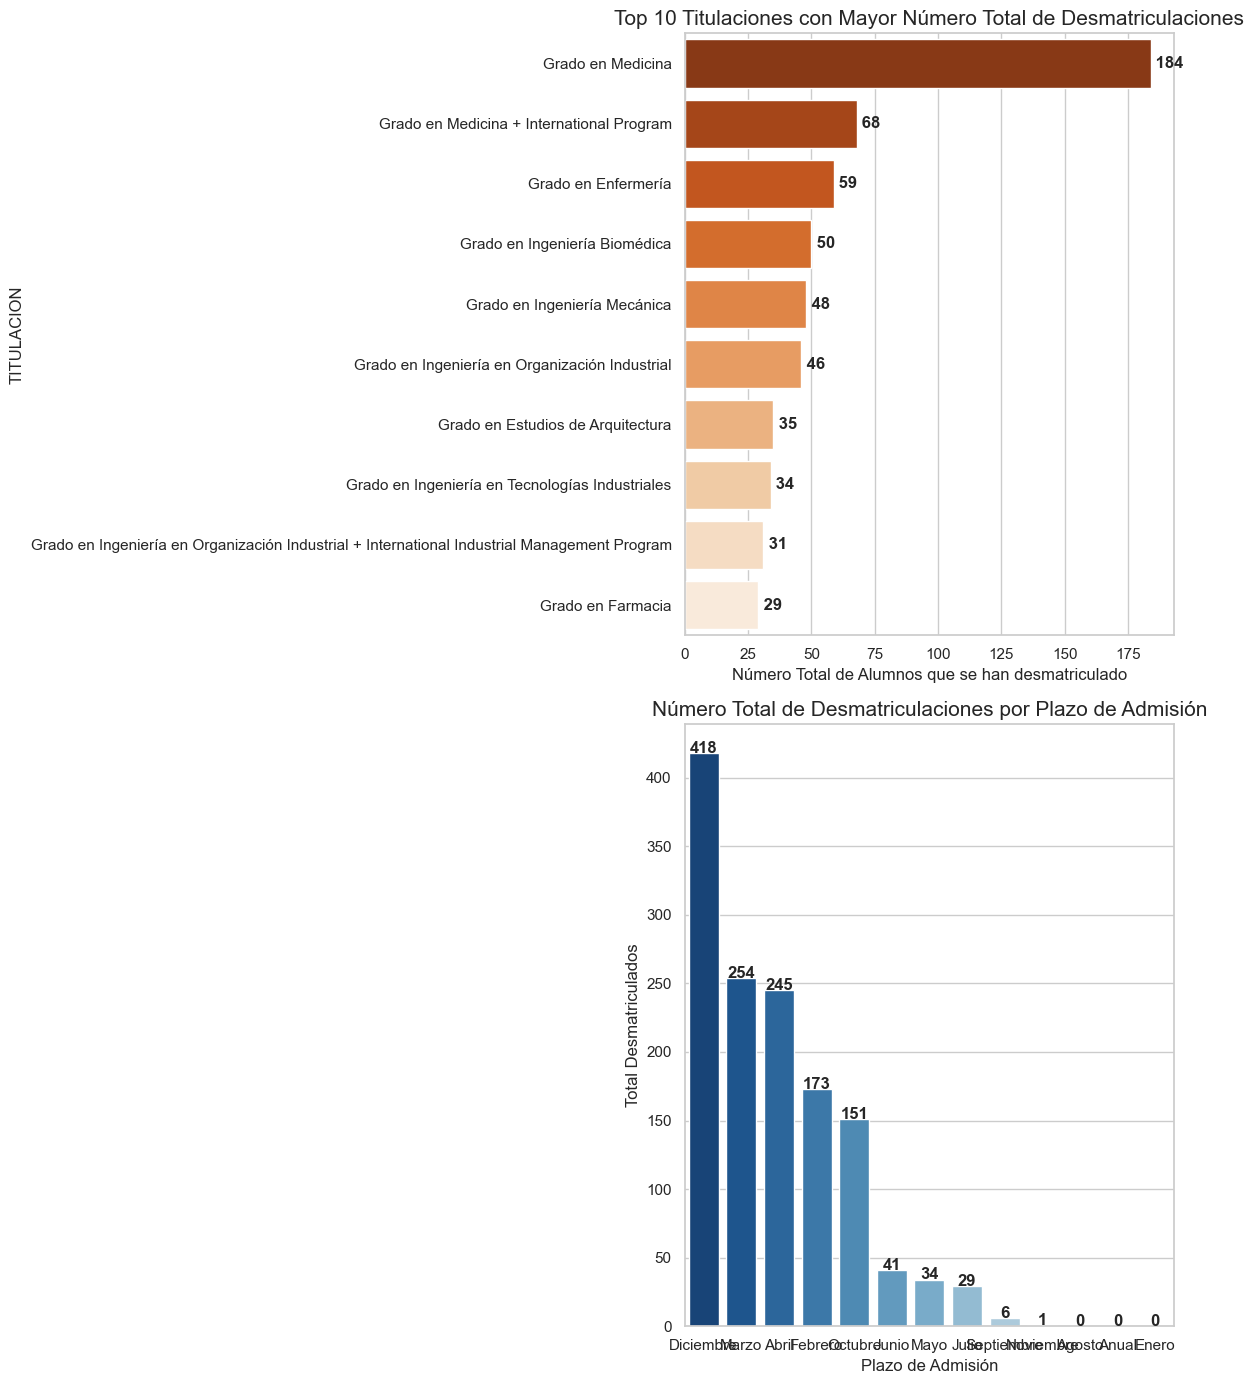

NÚMERO TOTAL DE DESMATRICULACIONES POR PLAZO:
---------------------------------------------
Plazo de Admisión  Total Desmatriculaciones
        Diciembre                       418
            Marzo                       254
            Abril                       245
          Febrero                       173
          Octubre                       151
            Junio                        41
             Mayo                        34
            Julio                        29
       Septiembre                         6
        Noviembre                         1
           Agosto                         0
            Anual                         0
            Enero                         0
---------------------------------------------
Total global de desmatriculaciones: 1352


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo
sns.set_theme(style="whitegrid")

# 1. Preparar datos por Titulación (Volumen total)
tit_bajas = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().reset_index()
tit_bajas = tit_bajas.sort_values(by='desmatriculado', ascending=False).head(10)

# 2. Preparar datos por Plazo (Volumen total)
plazo_bajas = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].sum().reset_index()
plazo_bajas = plazo_bajas.sort_values(by='desmatriculado', ascending=False)

# Crear la figura
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# --- GRÁFICO 1: Volumen de Bajas por Titulación ---
# Corrección: hue='TITULACION' y legend=False
sns.barplot(
    data=tit_bajas, 
    x='desmatriculado', 
    y='TITULACION', 
    ax=axes[0], 
    palette='Oranges_r', 
    hue='TITULACION', 
    legend=False
)
axes[0].set_title('Top 10 Titulaciones con Mayor Número Total de Desmatriculaciones', fontsize=15)
axes[0].set_xlabel('Número Total de Alumnos que se han desmatriculado')

# Añadir etiquetas de valor
for i, bar in enumerate(axes[0].patches):
    valor = int(bar.get_width())
    axes[0].text(valor + 0.1, bar.get_y() + bar.get_height()/2, f' {valor}', va='center', fontweight='bold')

# --- GRÁFICO 2: Volumen de Bajas por Plazo de Admisión ---
# Corrección: hue='PL_PLAZO_ADMISION' y legend=False
sns.barplot(
    data=plazo_bajas, 
    x='PL_PLAZO_ADMISION', 
    y='desmatriculado', 
    ax=axes[1], 
    palette='Blues_r', 
    hue='PL_PLAZO_ADMISION', 
    legend=False
)
axes[1].set_title('Número Total de Desmatriculaciones por Plazo de Admisión', fontsize=15)
axes[1].set_ylabel('Total Desmatriculados')
axes[1].set_xlabel('Plazo de Admisión')

# Añadir etiquetas de valor
for i, bar in enumerate(axes[1].patches):
    valor = int(bar.get_height())
    axes[1].text(bar.get_x() + bar.get_width()/2, valor + 0.1, f'{valor}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# =========================================================
# CÁLCULO DE DESMATRICULACIONES POR PLAZO
# =========================================================

resumen_plazos = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].sum().reset_index()
resumen_plazos = resumen_plazos.sort_values(by='desmatriculado', ascending=False)
resumen_plazos.columns = ['Plazo de Admisión', 'Total Desmatriculaciones']

print("NÚMERO TOTAL DE DESMATRICULACIONES POR PLAZO:")
print("-" * 45)
print(resumen_plazos.to_string(index=False))
print("-" * 45)
print(f"Total global de desmatriculaciones: {resumen_plazos['Total Desmatriculaciones'].sum()}")

En este caso, sí se ve que las carreras que engloban más desmatriculaciones son: *Medicina* (sin programa internacional y con programa internacional) y enfermería. También se puede ver, que los plazos de admisión que concentran más desmatriculaciones de forma global es diciembre.

A continuación, vamos a ver cómo se distribuyen las notas de admisión para las titulaciones que tienen más desmatriculados de forma global.

TABLA COMPARATIVA: TOP 5 TITULACIONES CON MÁS BAJAS


,Titulacion,Total_Matriculados,Nota_Media_Mat,Total_Desmatriculados,Nota_Media_Des
3,Grado en Medicina,556,7.13,184,7.24
4,Grado en Medicina + International Program,319,6.50,65,6.70
0,Grado en Enfermería,357,6.71,58,7.04
1,Grado en Ingeniería Biomédica,139,7.49,46,7.38
2,Grado en Ingeniería Mecánica,193,7.55,46,7.18


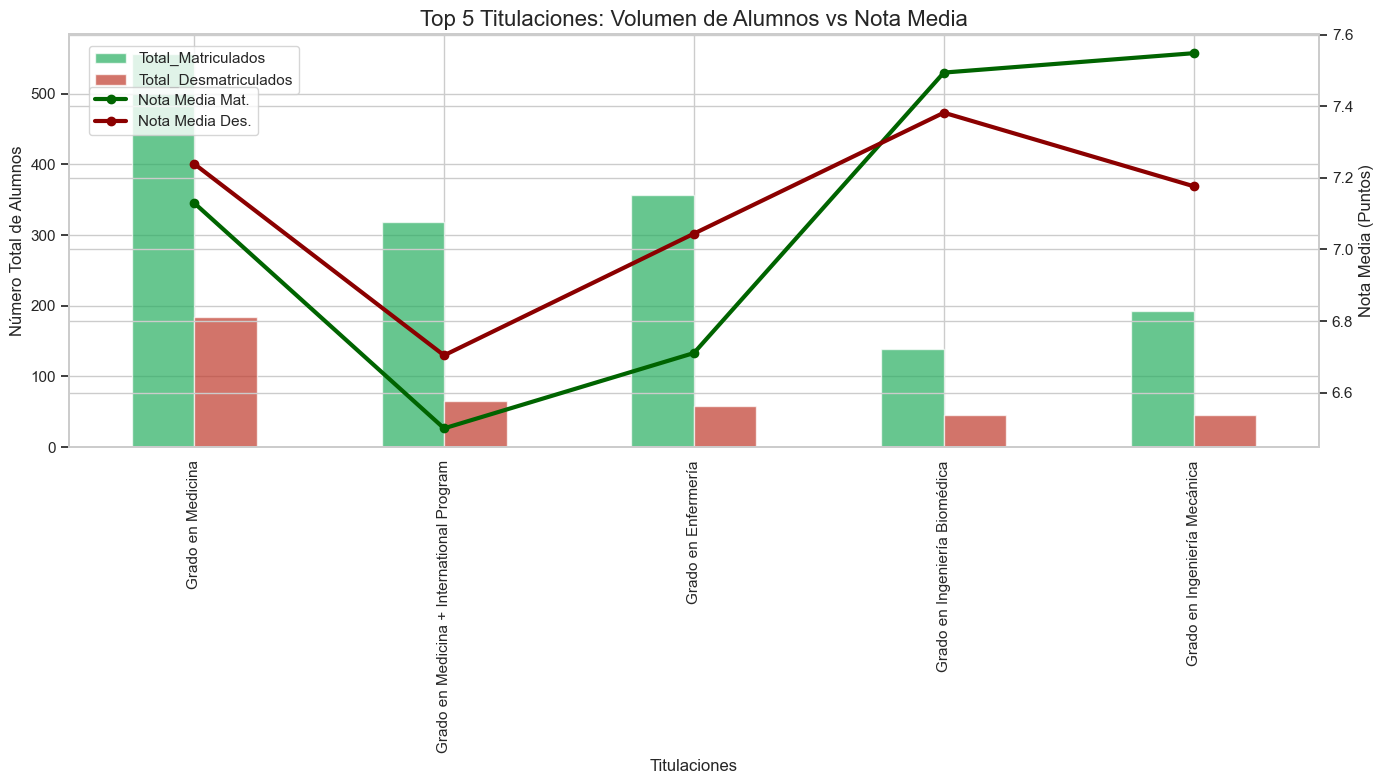

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identificar las 5 titulaciones con más desmatriculados
top_5_titulaciones = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtrar el dataset solo para esas titulaciones y separar grupos
df_top5 = datos_analisis[datos_analisis['TITULACION'].isin(top_5_titulaciones)]

df_mat = df_top5[(df_top5['target'] == 1) & (df_top5['desmatriculado'] == 0)]
df_des = df_top5[df_top5['desmatriculado'] == 1]

# 3. Agrupar por Titulación para obtener Volumen y Nota Media
stats_mat = df_mat.groupby('TITULACION')['NU_RESULTADO_ADMISION_PUNTOS'].agg(['count', 'mean']).reset_index()
stats_des = df_des.groupby('TITULACION')['NU_RESULTADO_ADMISION_PUNTOS'].agg(['count', 'mean']).reset_index()

# Unir en tabla comparativa
resumen_tit = pd.merge(stats_mat, stats_des, on='TITULACION', how='outer', suffixes=('_Mat', '_Des')).fillna(0)
resumen_tit.columns = ['Titulacion', 'Total_Matriculados', 'Nota_Media_Mat', 'Total_Desmatriculados', 'Nota_Media_Des']
resumen_tit = resumen_tit.sort_values(by='Total_Desmatriculados', ascending=False)

# 4. Mostrar la Tabla
print("TABLA COMPARATIVA: TOP 5 TITULACIONES CON MÁS BAJAS")
display(resumen_tit.round(2))

# 5. Gráfico Combinado
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Barras para el número total de personas
resumen_tit.plot(x='Titulacion', y=['Total_Matriculados', 'Total_Desmatriculados'], 
                 kind='bar', ax=ax1, color=['#27ae60', '#c0392b'], alpha=0.7)

# Líneas para las notas medias
# Usamos el índice para posicionar los puntos sobre las barras
x_coords = range(len(resumen_tit))
ax2.plot(x_coords, resumen_tit['Nota_Media_Mat'], marker='o', color='darkgreen', label='Nota Media Mat.', linewidth=3)
ax2.plot(x_coords, resumen_tit['Nota_Media_Des'], marker='o', color='darkred', label='Nota Media Des.', linewidth=3)

# Configuración de ejes y títulos
ax1.set_title('Top 5 Titulaciones: Volumen de Alumnos vs Nota Media', fontsize=16)
ax1.set_ylabel('Número Total de Alumnos', fontsize=12)
ax2.set_ylabel('Nota Media (Puntos)', fontsize=12)
ax1.set_xlabel('Titulaciones', fontsize=12)

# Ajustar leyenda
ax1.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.89))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Aquí, se puede observar que las notas de admisión suelen ser ligeramente más altas entre los desmatriculados que en los matriculados en las carreras de Medicina y Enfermería, en cambio, ocurre lo contrario para Ingeniería Biomédica e Ingeniería Mecánica.

Por último se puede ver una tabla para comprobar las notas medias por plazo de admisión y por matriculados y no matriculados en las titulaciones con un mayor número de desmatriculados:

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identificar las 5 titulaciones con más desmatriculados
top_5_titulaciones = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtrar y preparar los datos
df_top5 = datos_analisis[datos_analisis['TITULACION'].isin(top_5_titulaciones)].copy()

def definir_estado(row):
    if row['desmatriculado'] == 1:
        return 'Desmatriculado'
    elif row['target'] == 1:
        return 'Matriculado'
    return 'Otros'

df_top5['Estado'] = df_top5.apply(definir_estado, axis=1)
df_final = df_top5[df_top5['Estado'].isin(['Matriculado', 'Desmatriculado'])].copy()

# =================================================================
# LIMPIEZA DE NAs EN NOTAS
# =================================================================
# Eliminamos filas donde la nota de admisión sea NaN
df_final = df_final.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS'])

# Opcional: Eliminar también filas donde el Plazo sea NaN si fuera necesario
df_final = df_final.dropna(subset=['PL_PLAZO_ADMISION'])
# =================================================================

# 3. ANÁLISIS EN TABLA: Nota media
# Usamos dropna() en el groupby para evitar filas de NAs en la tabla
tabla_detalle = df_final.groupby(['TITULACION', 'PL_PLAZO_ADMISION', 'Estado'])['NU_RESULTADO_ADMISION_PUNTOS'].mean().unstack().round(2)

print("NOTA MEDIA: MATRICULADOS VS DESMATRICULADOS POR PLAZO Y TITULACIÓN (Sin NaNs)")
display(tabla_detalle)


NOTA MEDIA: MATRICULADOS VS DESMATRICULADOS POR PLAZO Y TITULACIÓN (Sin NaNs)


Estado                                                       Desmatriculado  \
TITULACION                                PL_PLAZO_ADMISION                   
Grado en Enfermería                       Abril                        6.89   
                                          Diciembre                    7.60   
                                          Febrero                       NaN   
                                          Marzo                        6.88   
Grado en Ingeniería Biomédica             Abril                        7.62   
                                          Diciembre                    7.67   
                                          Febrero                      7.19   
                                          Junio                         NaN   
                                          Marzo                        7.31   
                                          Mayo                         6.12   
Grado en Ingeniería Mecánica              Abril                        6.82   
                                          Diciembre                    7.48   
                                          Febrero                      7.06   
                                          Julio                        7.68   
                                          Junio                        0.00   
                                          Marzo                        7.55   
                                          Mayo                         8.03   
Grado en Medicina                         Abril                        7.12   
                                          Febrero                       NaN   
                                          Marzo                        7.35   
Grado en Medicina + International Program Abril                        7.06   
                                          Diciembre                    4.64   
                                          Febrero                      4.27   
                                          Marzo                        7.39   

Estado                                                       Matriculado  
TITULACION                                PL_PLAZO_ADMISION               
Grado en Enfermería                       Abril                     6.49  
                                          Diciembre                 7.14  
                                          Febrero                   7.14  
                                          Marzo                     6.66  
Grado en Ingeniería Biomédica             Abril                     7.11  
                                          Diciembre                 7.63  
                                          Febrero                   7.26  
                                          Junio                     8.13  
                                          Marzo                     7.79  
                                          Mayo                      7.18  
Grado en Ingeniería Mecánica              Abril                     7.58  
                                          Diciembre                 7.49  
                                          Febrero                   7.60  
                                          Julio                     7.99  
                                          Junio                      NaN  
                                          Marzo                     7.67  
                                          Mayo                       NaN  
Grado en Medicina                         Abril                     7.13  
                                          Febrero                   6.16  
                                          Marzo                     7.13  
Grado en Medicina + International Program Abril                     7.34  
                                          Diciembre                 3.93  
                                          Febrero                   4.43  
                                          Marzo                     7.

## Análisis del perfil económico y las becas

En este apartado queremos intentar dar respuesta a las siguientes preguntas:

1. ¿Cómo se distribuyen las rentas familiares en función del target? ¿Cómo influye el porcentaje de beca en si se ha matriculado o no?

2. ¿Qué porcentaje de alumnos hijos de empleados o hijos de profesores asociados se matriculan? ¿Es más alta la tasa de matriculación del resto de personas?

3. ¿Cómo influye el colegio de origen en la tasa de matriculación? ¿Cuáles son los colegios de origen que tienen una mayor tasa de matriculados?


En primer lugar, vamos a comparar cómo se distribuyen los matriculados y los no matriculados en función de la renta familiar y el porcentaje de beca (a mayor porcentaje de beca, más descuento tiene el alumno).

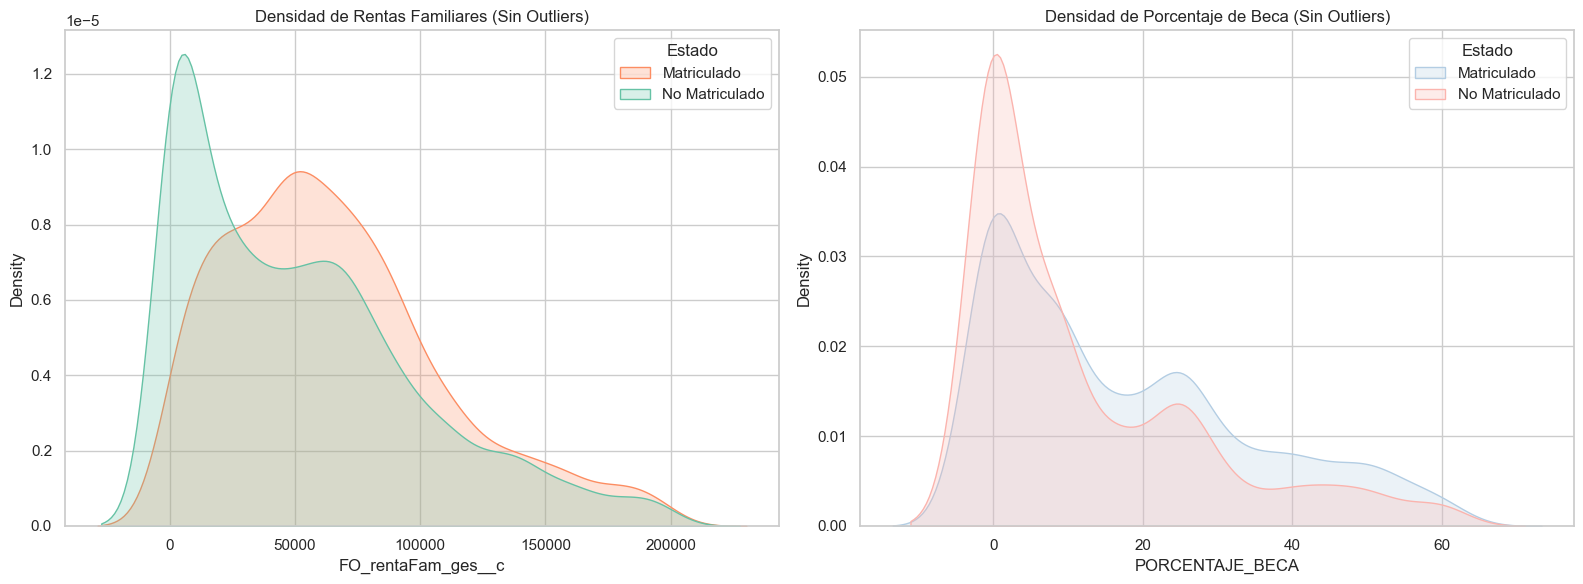

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estética
sns.set_theme(style="whitegrid")

# --- Preparación de variables y limpieza de outliers ---
datos_analisis['PORCENTAJE_BECA'] = (1 - (datos_analisis['CU_precioAplicado_def__c'] / datos_analisis['CU_precioOrdinario_def__c'])) * 100

def limpiar_outliers_df(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[columna] >= lower) & (df[columna] <= upper)]

# Limpiamos para las gráficas de distribución (eliminando NaNs también)
df_renta_clean = limpiar_outliers_df(datos_analisis.dropna(subset=['FO_rentaFam_ges__c']), 'FO_rentaFam_ges__c')
df_beca_clean = limpiar_outliers_df(datos_analisis.dropna(subset=['PORCENTAJE_BECA']), 'PORCENTAJE_BECA')

# =========================================================
# 1. DISTRIBUCIÓN DE RENTAS Y BECAS (KDE Plots)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribución de Rentas
sns.kdeplot(data=df_renta_clean, x='FO_rentaFam_ges__c', hue='target', 
            fill=True, common_norm=False, palette='Set2', ax=axes[0])
axes[0].set_title('Densidad de Rentas Familiares (Sin Outliers)')
axes[0].legend(title='Estado', labels=['Matriculado', 'No Matriculado'])

# Distribución de % de Beca
sns.kdeplot(data=df_beca_clean, x='PORCENTAJE_BECA', hue='target', 
            fill=True, common_norm=False, palette='Pastel1', ax=axes[1])
axes[1].set_title('Densidad de Porcentaje de Beca (Sin Outliers)')
axes[1].legend(title='Estado', labels=['Matriculado', 'No Matriculado'])

plt.tight_layout()
plt.show()


Aquí se puede observar dos cosas:

1. Respecto a la renta familiar, las rentas bajas tienen menor número de matriculados. En cambio, a medida que aumenta la renta familiar, el número de matriculados aumenta, superando al número de no matriculados con rentas similares.

2. Si observamos el porcentaje de beca, en porcentajs de beca pequeños (menos del 15%) hay un mayor número de desmatriculados. En cambio, a medida que aumenta el porcentaje de beca, el número de matriculados es superior al de no matriculados.

Ahora vamos a realizar un análisis de la tasa de matriculación según si se trata de hijos de empleados, de profesores asociados o no cuenta con ninguno de los beneficios:

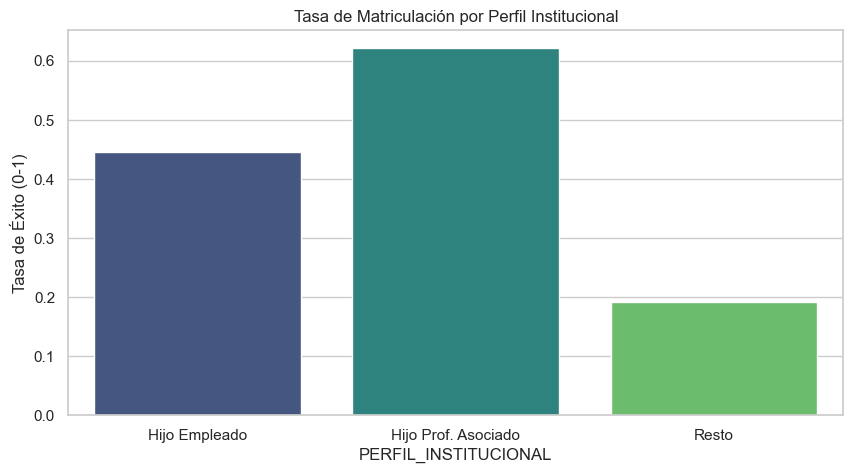

In [11]:
# =========================================================
# 2. HIJOS DE EMPLEADOS Y PROFESORES
# =========================================================
def segmentar_perfil(row):
    if row['CH_HIJO_EMPLEADO__PC'] == 1: return 'Hijo Empleado'
    if row['CH_HIJO_PROFESOR_ASOCIADO__PC'] == 1: return 'Hijo Prof. Asociado'
    return 'Resto'

datos_analisis['PERFIL_INSTITUCIONAL'] = datos_analisis.apply(segmentar_perfil, axis=1)
perfil_stats = datos_analisis.groupby('PERFIL_INSTITUCIONAL')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=perfil_stats, x='PERFIL_INSTITUCIONAL', y='target', 
            palette='viridis', hue='PERFIL_INSTITUCIONAL', legend=False)
plt.title('Tasa de Matriculación por Perfil Institucional')
plt.ylabel('Tasa de Éxito (0-1)')
plt.show()


Aquí se puede observar que la tasa de matriculación es muy superior en aquellos alumnos que cuentan con beneficios. En cambio, dentro de los alumnos con beneficios, la tasa de matriculación es muy superior entre los hijos de los profesores asociados.

Ahora veremos un gráfico con los colegios con mayor tasa de conversión:

TOP 10 COLEGIOS CON MAYOR TASA DE MATRICULACIÓN:


,CENTROENSENANZA,Total_Alumnos,Tasa_Conversion
3904,I.E.S. Reyes Católicos,6,0.833333
6511,Universidad Católica de El Salvador,8,0.750000
5682,St. John XXIII College Preparatory,7,0.714286
6717,Universidad de Montevideo,25,0.680000
6096,UNIVERSIDAD DE GIRONA,9,0.666667
5692,St. Martin's Academy,9,0.666667
6618,Universidad Notre Dame de Haití,6,0.666667
6590,Universidad Latinoamericana de Ciencia y Tecno...,6,0.666667
3469,I.E.S. CELSO DIAZ,6,0.666667
6082,UNIVERSIDAD DE CASTILLA LA MANCHA,8,0.625000


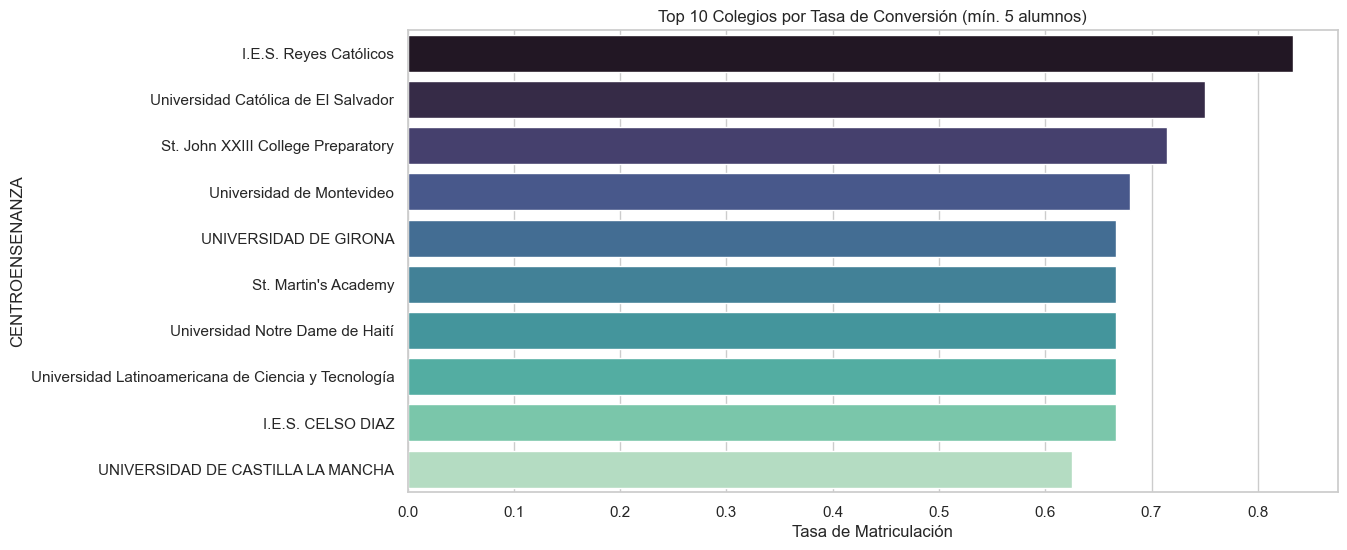

In [12]:
# =========================================================
# 3. COLEGIOS DE ORIGEN
# =========================================================
colegios = datos_analisis.groupby('CENTROENSENANZA')['target'].agg(['count', 'mean']).reset_index()
colegios = colegios[colegios['count'] > 5].sort_values(by='mean', ascending=False)

print("TOP 10 COLEGIOS CON MAYOR TASA DE MATRICULACIÓN:")
display(colegios.head(10).rename(columns={'count': 'Total_Alumnos', 'mean': 'Tasa_Conversion'}))

plt.figure(figsize=(12, 6))
top_10_col = colegios.head(10)
sns.barplot(data=top_10_col, x='mean', y='CENTROENSENANZA', 
            palette='mako', hue='CENTROENSENANZA', legend=False)
plt.title('Top 10 Colegios por Tasa de Conversión (mín. 5 alumnos)')
plt.xlabel('Tasa de Matriculación')
plt.show()

## Análisis de las notas

En este apartado queremos analizar el conjunto de datos para intentar dar respuesta a las siguientes preguntas:

1. ¿Influye los plazos en el porcentaje de matrícula? ¿Hay muchos menos matriculados en diciembre que en marzo o en rolling? ¿Qué notas de admisión tienen cada uno?

2. ¿Hay mucha diferencia en las tasas de matriculados por carrera y plazo en el que se presenta?

3. ¿Qué perfil de alumno se presenta en Diciembre, en Marzo y en Rolling? ¿Qué diferencia hay entre ellos? ¿Cuándo se producen más desmatriculaciones?

4. ¿Qué notas tienen los matriculados por titulación? ¿Qué notas tienen los matriculados por plazo de admisión y título?

En primer lugar, veremos un gráfico con el volumen de oportunidades por plazo de admisión y la tasa de matriculación de cada uno de ellos:

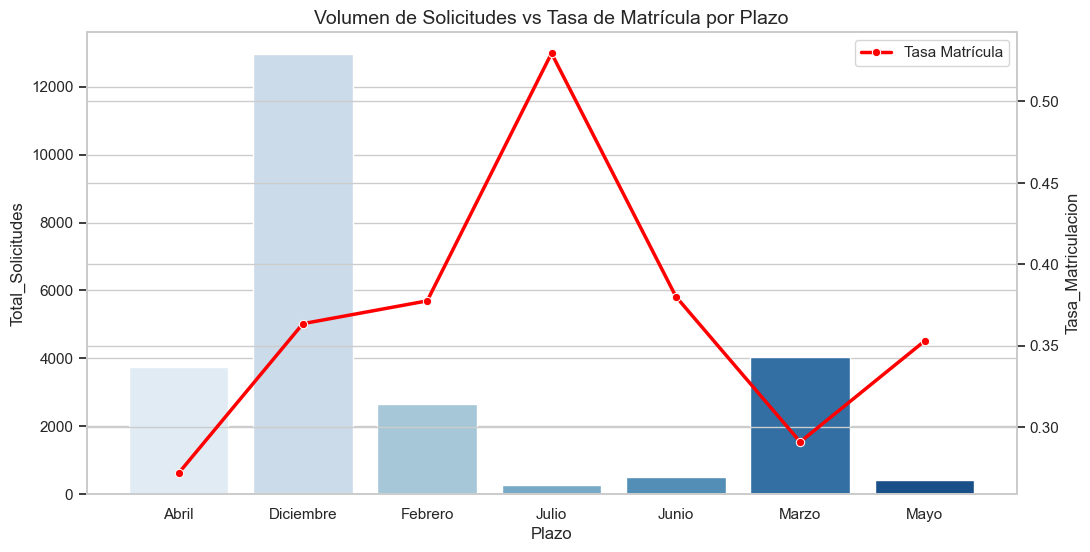

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración inicial
sns.set_theme(style="whitegrid")

# 1. Limpieza de datos previa para evitar errores en el análisis de notas
df_clean = datos_analisis.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS', 'PL_PLAZO_ADMISION']).copy()

# =========================================================
# 1. ANÁLISIS DE PLAZOS: VOLUMEN, % ÉXITO Y NOTAS
# =========================================================
# Calculamos estadísticas por plazo
plazo_stats = df_clean.groupby('PL_PLAZO_ADMISION').agg({
    'target': ['count', 'mean'],
    'NU_RESULTADO_ADMISION_PUNTOS': 'mean'
}).reset_index()
plazo_stats.columns = ['Plazo', 'Total_Solicitudes', 'Tasa_Matriculacion', 'Nota_Media']

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Barras: Volumen / Línea: Tasa de éxito
sns.barplot(data=plazo_stats, x='Plazo', y='Total_Solicitudes', ax=ax1, palette='Blues', hue='Plazo', legend=False)
sns.lineplot(data=plazo_stats, x='Plazo', y='Tasa_Matriculacion', ax=ax2, color='red', marker='o', linewidth=2.5, label='Tasa Matrícula')

ax1.set_title('Volumen de Solicitudes vs Tasa de Matrícula por Plazo', fontsize=14)
plt.show()



Aquí podemos ver que el plazo con mayor volumen de oportunidades es Diciembre. En cambio, en plazo en el que menos oportunidades hay es Julio, pero presenta la mayor tasa de matriculaciones.

Ahora vamos a realizar un gráfico para revisar la distribución de las notas de admisión por plazo. También veremos la tasa de desmatriculación por plazo:

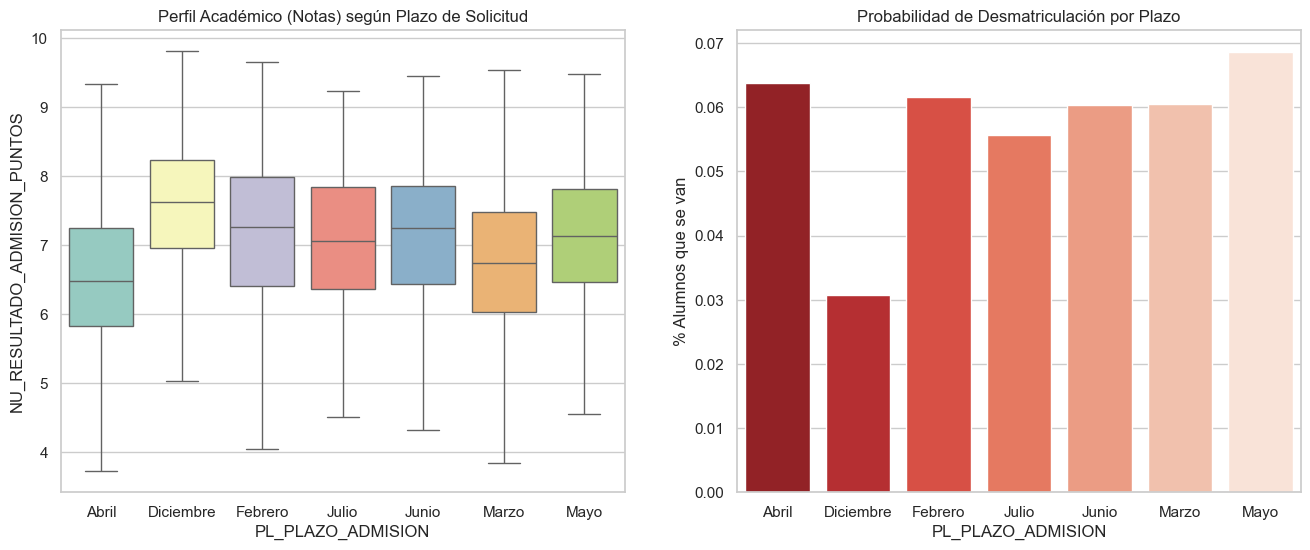

In [18]:
# =========================================================
# 3. PERFIL POR PLAZO Y DESMATRICULACIONES
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Perfil académico por plazo
sns.boxplot(data=df_clean, x='PL_PLAZO_ADMISION', y='NU_RESULTADO_ADMISION_PUNTOS', 
            ax=axes[0], palette='Set3', hue='PL_PLAZO_ADMISION', legend=False, showfliers=False)
axes[0].set_title('Perfil Académico (Notas) según Plazo de Solicitud')

# Desmatriculaciones por plazo
desmat_stats = df_clean.groupby('PL_PLAZO_ADMISION')['desmatriculado'].mean().reset_index()
sns.barplot(data=desmat_stats, x='PL_PLAZO_ADMISION', y='desmatriculado', 
            ax=axes[1], palette='Reds_r', hue='PL_PLAZO_ADMISION', legend=False)
axes[1].set_title('Probabilidad de Desmatriculación por Plazo')
axes[1].set_ylabel('% Alumnos que se van')

plt.show()

Aquí se pueden observar varios temas:

1. En diciembre se presentan aquellos alumnos con mejores resultados académicos, ya que sus notas son claramente superiores al resto de alumnos que se presentan en otros plazos.

2. La tasa de desmatriculaciones; es decir, el número de desmatriculaciones entre el total de oportunidades es más bajo en diciembre, ya que hay que tener en cuenta que es el plazo de admisión con mayor volumen de oportunidades. En el resto de plazos, las tasas son parecidas, excepto en mayo que es ligeramente superior al resto.

Por último, vamos a ver la tasa de matriculación por titulación y plazo de admisión:

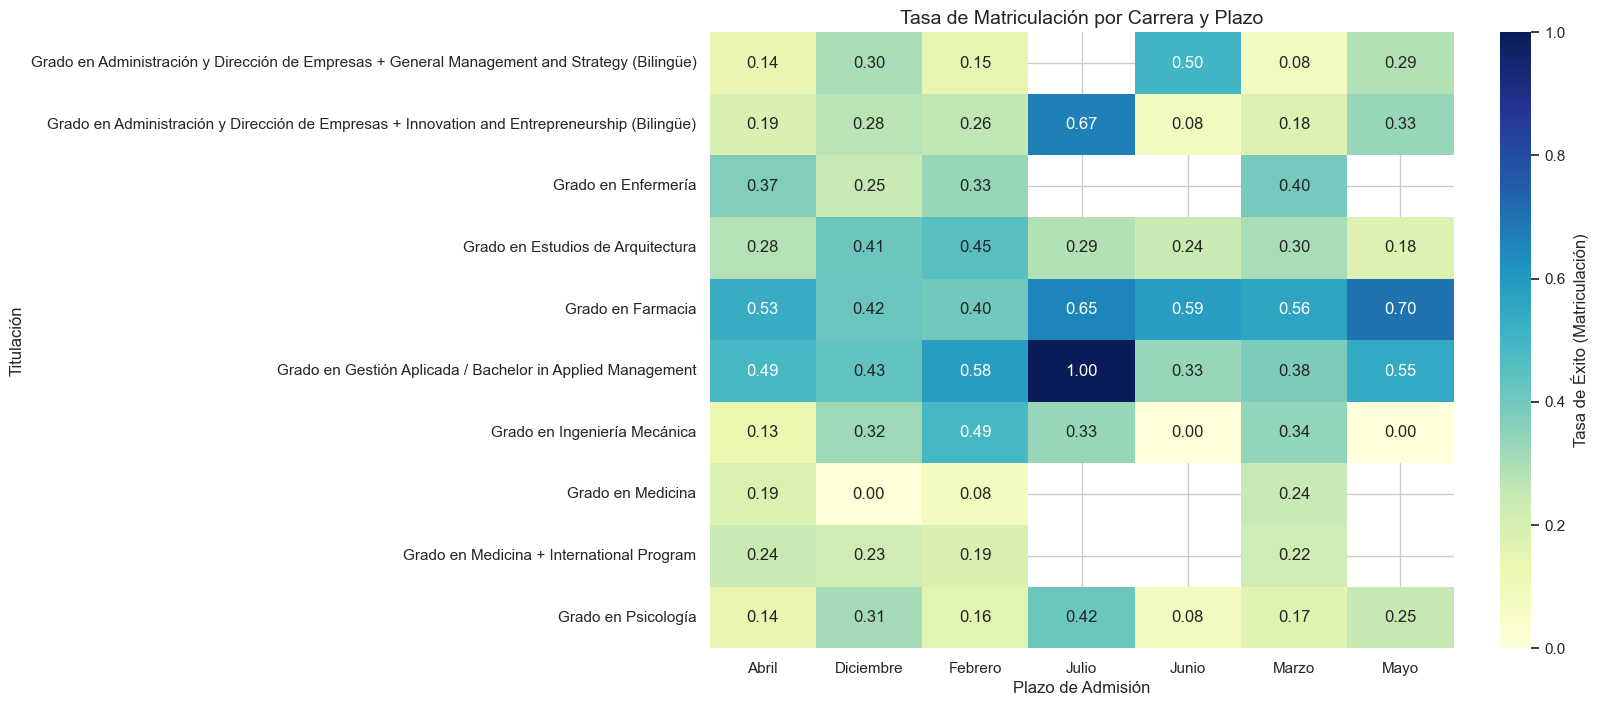

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Limpieza y preparación (Top 10 titulaciones)
df_clean = datos_analisis.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS', 'PL_PLAZO_ADMISION']).copy()
top_tit = df_clean['TITULACION'].value_counts().head(10).index
df_top = df_clean[df_clean['TITULACION'].isin(top_tit)]

# 2. Creación de la tabla pivote
pivot_tasa = df_top.pivot_table(index='TITULACION', columns='PL_PLAZO_ADMISION', values='target', aggfunc='mean')

# =========================================================
# GRÁFICO CORREGIDO: Mapa de Calor
# =========================================================
plt.figure(figsize=(12, 8))

# Corregido: Usamos cbar_kws para poner la etiqueta a la barra de color
sns.heatmap(pivot_tasa, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu", 
            cbar_kws={'label': 'Tasa de Éxito (Matriculación)'})

plt.title('Tasa de Matriculación por Carrera y Plazo', fontsize=14)
plt.xlabel('Plazo de Admisión')
plt.ylabel('Titulación')
plt.show()



Aquí se puede observar para cada titulación, las distintas tasas de matriculación en función del plazo de admisión. Por ejemplo, en Farmacia son más altas a medida que nos acercamos a junio-julio. En medicina y enfermería, es más alta en marzo y abril que en febrero.